# 1 - Simple Sentiment Analysis

In this series we'll be building a machine learning model to detect sentiment (i.e. detect if a sentence is positive or negative) using PyTorch and TorchText. This will be done on movie reviews, using the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

In this first notebook, we'll start very simple to understand the general concepts whilst not really caring about good results. Further notebooks will build on this knowledge and we'll actually get good results.

### Introduction

We'll be using a **recurrent neural network** (RNN) as they are commonly used in analysing sequences. An RNN takes in sequence of words, $X=\{x_1, ..., x_T\}$, one at a time, and produces a _hidden state_, $h$, for each word. We use the RNN _recurrently_ by feeding in the current word $x_t$ as well as the hidden state from the previous word, $h_{t-1}$, to produce the next hidden state, $h_t$.

$$h_t = \text{RNN}(x_t, h_{t-1})$$

Once we have our final hidden state, $h_T$, (from feeding in the last word in the sequence, $x_T$) we feed it through a linear layer, $f$, (also known as a fully connected layer), to receive our predicted sentiment, $\hat{y} = f(h_T)$.

Below shows an example sentence, with the RNN predicting zero, which indicates a negative sentiment. The RNN is shown in orange and the linear layer shown in silver. Note that we use the same RNN for every word, i.e. it has the same parameters. The initial hidden state, $h_0$, is a tensor initialized to all zeros.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment1.png?raw=1)

**Note:** some layers and steps have been omitted from the diagram, but these will be explained later.

## Preparing Data

One of the main concepts of TorchText is the `Field`. These define how your data should be processed. In our sentiment classification task the data consists of both the raw string of the review and the sentiment, either "pos" or "neg".

The parameters of a `Field` specify how the data should be processed.

We use the `TEXT` field to define how the review should be processed, and the `LABEL` field to process the sentiment.

Our `TEXT` field has `tokenize='spacy'` as an argument. This defines that the "tokenization" (the act of splitting the string into discrete "tokens") should be done using the [spaCy](https://spacy.io) tokenizer. If no `tokenize` argument is passed, the default is simply splitting the string on spaces. We also need to specify a `tokenizer_language` which tells torchtext which spaCy model to use. We use the `en_core_web_sm` model which has to be downloaded with `python -m spacy download en_core_web_sm` before you run this notebook!

`LABEL` is defined by a `LabelField`, a special subset of the `Field` class specifically used for handling labels. We will explain the `dtype` argument later.

For more on `Fields`, go [here](https://github.com/pytorch/text/blob/master/torchtext/data/field.py).

We also set the random seeds for reproducibility.

In [1]:
!pip install torchtext==0.4.0
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [2]:
import torch
from torchtext import data


from gensim.test.utils import common_texts
from gensim.models import Word2Vec
# word2vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")


SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  pad_first=True)

LABEL = data.LabelField(dtype = torch.float)

Another handy feature of TorchText is that it has support for common datasets used in natural language processing (NLP).

The following code automatically downloads the IMDb dataset and splits it into the canonical train/test splits as `torchtext.datasets` objects. It process the data using the `Fields` we have previously defined. The IMDb dataset consists of 50,000 movie reviews, each marked as being a positive or negative review.

In [3]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:30<00:00, 2.71MB/s]


We can see how many examples are in each split by checking their length.

In [4]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


We can also check an example.

In [5]:
print(vars(train_data.examples[0]))

{'text': ['Worry', 'not', ',', 'Disney', 'fans', '--', 'this', 'special', 'edition', 'DVD', 'of', 'the', 'beloved', 'Cinderella', 'wo', "n't", 'turn', 'into', 'a', 'pumpkin', 'at', 'the', 'strike', 'of', 'midnight', '.', 'One', 'of', 'the', 'most', 'enduring', 'animated', 'films', 'of', 'all', 'time', ',', 'the', 'Disney', '-', 'fide', 'adaptation', 'of', 'the', 'gory', 'Brothers', 'Grimm', 'fairy', 'tale', 'became', 'a', 'classic', 'in', 'its', 'own', 'right', ',', 'thanks', 'to', 'some', 'memorable', 'tunes', '(', 'including', '"', 'A', 'Dream', 'Is', 'a', 'Wish', 'Your', 'Heart', 'Makes', ',', '"', '"', 'Bibbidi', '-', 'Bobbidi', '-', 'Boo', ',', '"', 'and', 'the', 'title', 'song', ')', 'and', 'some', 'endearingly', 'cute', 'comic', 'relief', '.', 'The', 'famous', 'slipper', '(', 'click', 'for', 'larger', 'image', ')', 'We', 'all', 'know', 'the', 'story', '--', 'the', 'wicked', 'stepmother', 'and', 'stepsisters', 'simply', 'wo', "n't", 'have', 'it', ',', 'this', 'uppity', 'Cinderell

The IMDb dataset only has train/test splits, so we need to create a validation set. We can do this with the `.split()` method.

By default this splits 70/30, however by passing a `split_ratio` argument, we can change the ratio of the split, i.e. a `split_ratio` of 0.8 would mean 80% of the examples make up the training set and 20% make up the validation set.

We also pass our random seed to the `random_state` argument, ensuring that we get the same train/validation split each time.

In [6]:
import random

train_data, valid_data = train_data.split(split_ratio = 0.8, random_state = random.seed(SEED))

Again, we'll view how many examples are in each split.

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000


Next, we have to build a _vocabulary_. This is a effectively a look up table where every unique word in your data set has a corresponding _index_ (an integer).

We do this as our machine learning model cannot operate on strings, only numbers. Each _index_ is used to construct a _one-hot_ vector for each word. A one-hot vector is a vector where all of the elements are 0, except one, which is 1, and dimensionality is the total number of unique words in your vocabulary, commonly denoted by $V$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment5.png?raw=1)

The number of unique words in our training set is over 100,000, which means that our one-hot vectors will have over 100,000 dimensions! This will make training slow and possibly won't fit onto your GPU (if you're using one).

There are two ways effectively cut down our vocabulary, we can either only take the top $n$ most common words or ignore words that appear less than $m$ times. We'll do the former, only keeping the top 25,000 words.

What do we do with words that appear in examples but we have cut from the vocabulary? We replace them with a special _unknown_ or `<unk>` token. For example, if the sentence was "This film is great and I love it" but the word "love" was not in the vocabulary, it would become "This film is great and I `<unk>` it".

The following builds the vocabulary, only keeping the most common `max_size` tokens.

In [8]:
# print number of unique words

TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)
print(len(TEXT.vocab))
print(len(LABEL.vocab))

print(LABEL.vocab.stoi)
# here I see that hte length of the label vocabulary is only 2 long?
# This is because we have postive and negative only
print(LABEL.vocab.itos) # wtf is itos..,

108128
2
defaultdict(None, {'neg': 0, 'pos': 1})
['neg', 'pos']


In [9]:
MAX_VOCAB_SIZE = 25_000

# MAX_VOCAB_SIZE = 0

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

print(len(TEXT.vocab)) # why is this MAX_VOCAB_SIZE +2 ?  <unk> and <pad>
print(len(LABEL.vocab))


25002
2


Why do we only build the vocabulary on the training set? When testing any machine learning system you do not want to look at the test set in any way. We do not include the validation set as we want it to reflect the test set as much as possible.

In [10]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


Why is the vocab size 25002 and not 25000? One of the addition tokens is the `<unk>` token and the other is a `<pad>` token.

When we feed sentences into our model, we feed a _batch_ of them at a time, i.e. more than one at a time, and all sentences in the batch need to be the same size. Thus, to ensure each sentence in the batch is the same size, any shorter than the longest within the batch are padded.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment6.png?raw=1)

We can also view the most common words in the vocabulary and their frequencies.

In [11]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 231121), (',', 219061), ('.', 189004), ('and', 124763), ('a', 124701), ('of', 114770), ('to', 106826), ('is', 86846), ('in', 69887), ('I', 62174), ('it', 60990), ('that', 56003), ('"', 50388), ("'s", 49507), ('this', 48224), ('-', 43085), ('/><br', 40753), ('was', 40049), ('as', 34761), ('with', 33992)]


We can also see the vocabulary directly using either the `stoi` (**s**tring **to** **i**nt) or `itos` (**i**nt **to**  **s**tring) method.

In [12]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


We can also check the labels, ensuring 0 is for negative and 1 is for positive.

In [13]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [14]:
TEXT.__dict__

{'sequential': True,
 'use_vocab': True,
 'init_token': None,
 'eos_token': None,
 'unk_token': '<unk>',
 'fix_length': None,
 'dtype': torch.int64,
 'preprocessing': None,
 'postprocessing': None,
 'lower': False,
 'tokenizer_args': ('spacy', 'en_core_web_sm'),
 'tokenize': functools.partial(<function _spacy_tokenize at 0x7e21d38a4820>, spacy=<spacy.lang.en.English object at 0x7e21a1170dc0>),
 'include_lengths': True,
 'batch_first': False,
 'pad_token': '<pad>',
 'pad_first': True,
 'truncate_first': False,
 'stop_words': None,
 'is_target': False,
 'vocab': <torchtext.vocab.Vocab at 0x7e21b81e89a0>}

The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

We'll use a `BucketIterator` which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

We also want to place the tensors returned by the iterator on the GPU (if you're using one). PyTorch handles this using `torch.device`, we then pass this device to the iterator.

In [15]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Build the Model

The next stage is building the model that we'll eventually train and evaluate.

There is a small amount of boilerplate code when creating models in PyTorch, note how our `RNN` class is a sub-class of `nn.Module` and the use of `super`.

Within the `__init__` we define the _layers_ of the module. Our three layers are an _embedding_ layer, our RNN, and a _linear_ layer. All layers have their parameters initialized to random values, unless explicitly specified.

The embedding layer is used to transform our sparse one-hot vector (sparse as most of the elements are 0) into a dense embedding vector (dense as the dimensionality is a lot smaller and all the elements are real numbers). This embedding layer is simply a single fully connected layer. As well as reducing the dimensionality of the input to the RNN, there is the theory that words which have similar impact on the sentiment of the review are mapped close together in this dense vector space. For more information about word embeddings, see [here](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/).

The RNN layer is our RNN which takes in our dense vector and the previous hidden state $h_{t-1}$, which it uses to calculate the next hidden state, $h_t$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment7.png?raw=1)

Finally, the linear layer takes the final hidden state and feeds it through a fully connected layer, $f(h_T)$, transforming it to the correct output dimension.

The `forward` method is called when we feed examples into our model.

Each batch, `text`, is a tensor of size _**[sentence length, batch size]**_. That is a batch of sentences, each having each word converted into a one-hot vector.

You may notice that this tensor should have another dimension due to the one-hot vectors, however PyTorch conveniently stores a one-hot vector as it's index value, i.e. the tensor representing a sentence is just a tensor of the indexes for each token in that sentence. The act of converting a list of tokens into a list of indexes is commonly called *numericalizing*.

The input batch is then passed through the embedding layer to get `embedded`, which gives us a dense vector representation of our sentences. `embedded` is a tensor of size _**[sentence length, batch size, embedding dim]**_.

`embedded` is then fed into the RNN. In some frameworks you must feed the initial hidden state, $h_0$, into the RNN, however in PyTorch, if no initial hidden state is passed as an argument it defaults to a tensor of all zeros.

The RNN returns 2 tensors, `output` of size _**[sentence length, batch size, hidden dim]**_ and `hidden` of size _**[1, batch size, hidden dim]**_. `output` is the concatenation of the hidden state from every time step, whereas `hidden` is simply the final hidden state. We verify this using the `assert` statement. Note the `squeeze` method, which is used to remove a dimension of size 1.

Finally, we feed the last hidden state, `hidden`, through the linear layer, `fc`, to produce a prediction.

In [16]:
import torch.nn as nn
import torch.nn.functional as F


class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()


        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # Set up the RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim)

        # Set up the fully connected layer that outputs the prediction
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths=None):

        # Embedding layer
        embedded = self.embedding(text)

        # RNN layer
        output, hidden = self.rnn(embedded)


        # Fully connected layer
        return self.fc(hidden.squeeze(0))


# dynamic FFN
class FFN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dims, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # Dynamically create the fully connected layers based on hidden_dims
        layers = []
        in_features = embedding_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_features, hidden_dim))
            in_features = hidden_dim  # Update in_features for the next layer

        self.fc_layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(in_features, output_dim)

    def forward(self, text, text_lengths=None):
        # Embedding layer
        embedded = self.embedding(text)

        # Aggregate embeddings (mean over sequence dimension)
        output = embedded.mean(dim=0)

        # Dynamically apply each fully connected layer with ReLU activation
        for layer in self.fc_layers:
            output = F.relu(layer(output))

        # Output layer
        return self.output_layer(output)


# CNN model (using three feature maps with the sizes are 1, 2, and 3)
class CNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim_1, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # Set up the CNN layers
        self.cnn1 = nn.Conv1d(embedding_dim, hidden_dim_1, 1)
        self.cnn2 = nn.Conv1d(embedding_dim, hidden_dim_1, 2)
        self.cnn3 = nn.Conv1d(embedding_dim, hidden_dim_1, 3)

        # Set up the fully connected layer that outputs the prediction
        self.fc = nn.Linear(hidden_dim_1 * 3, output_dim)


    def forward(self, text, text_lengths=None):
        # text = [sent len, batch size]

        # Embedding layer
        embedded = self.embedding(text)

        # why do I need to do this?
        embedded = embedded.permute(1, 2, 0)
        # embedded = [batch size, emb dim, sent len]

        # CNN layer
        output1 = F.relu(self.cnn1(embedded))
        output2 = F.relu(self.cnn2(embedded))
        output3 = F.relu(self.cnn3(embedded))

        # Max pooling
        output1 = F.max_pool1d(output1, output1.shape[2]).squeeze(2)
        output2 = F.max_pool1d(output2, output2.shape[2]).squeeze(2)
        output3 = F.max_pool1d(output3, output3.shape[2]).squeeze(2)

        # Fully connected layer
        return self.fc(torch.cat((output1, output2, output3), dim=1))


class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, device=device):
        super().__init__()

        # Store the device in the model
        self.device = device

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=False)

        self.linear = nn.Linear(hidden_dim, output_dim)

        # Move the model itself to the specified device (GPU or CPU) couldn't get it to work otherwise...
        self.to(device)

    def forward(self, text, text_lengths=None):
        # Ensure inputs are on the correct device
        text = text.to(self.device)
        if text_lengths is not None:
            text_lengths = text_lengths.to('cpu').long()  # text_lengths must be on CPU for pack_padded_sequence

        embedded = self.embedding(text)

        # When using pack_padded_sequence, make sure to sort or enforce_sorted=False
        if text_lengths is not None:
            packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
            packed_output, (hidden, cell) = self.lstm(packed_embedded)
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        else:
            output, (hidden, cell) = self.lstm(embedded)

        # If you want to use only the last hidden state:
        out = self.linear(hidden[-1, :, :])

        return out

class BiLSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, device=device):
        super().__init__()

        # Store the device in the model
        self.device = device

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        self.linear = nn.Linear(hidden_dim, output_dim)

        # Move the model itself to the specified device (GPU or CPU) couldn't get it to work otherwise...
        self.to(device)

    def forward(self, text, text_lengths=None):
        # Ensure inputs are on the correct device
        text = text.to(self.device)
        if text_lengths is not None:
            text_lengths = text_lengths.to('cpu').long()  # text_lengths must be on CPU for pack_padded_sequence

        embedded = self.embedding(text)

        # When using pack_padded_sequence, make sure to sort or enforce_sorted=False
        if text_lengths is not None:
            packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
            packed_output, (hidden, cell) = self.lstm(packed_embedded)
            output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        else:
            output, (hidden, cell) = self.lstm(embedded)

        # If you want to use only the last hidden state:
        out = self.linear(hidden[-1, :, :])

        return out



We now create an instance of our RNN class.

The input dimension is the dimension of the one-hot vectors, which is equal to the vocabulary size.

The embedding dimension is the size of the dense word vectors. This is usually around 50-250 dimensions, but depends on the size of the vocabulary.

The hidden dimension is the size of the hidden states. This is usually around 100-500 dimensions, but also depends on factors such as on the vocabulary size, the size of the dense vectors and the complexity of the task.

The output dimension is usually the number of classes, however in the case of only 2 classes the output value is between 0 and 1 and thus can be 1-dimensional, i.e. a single scalar real number.

In [17]:
INPUT_DIM = len(TEXT.vocab)
# EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

# model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

Let's also create a function that will tell us how many trainable parameters our model has so we can compare the number of parameters across different models.

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f'The model has {count_parameters(model):,} trainable parameters')

## Train the Model

Now we'll set up the training and then train the model.

First, we'll create an optimizer. This is the algorithm we use to update the parameters of the module. Here, we'll use _stochastic gradient descent_ (SGD). The first argument is the parameters will be updated by the optimizer, the second is the learning rate, i.e. how much we'll change the parameters by when we do a parameter update.

In [19]:
# import torch.optim as optim
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

Next, we'll define our loss function. In PyTorch this is commonly called a criterion.

The loss function here is _binary cross entropy with logits_.

Our model currently outputs an unbound real number. As our labels are either 0 or 1, we want to restrict the predictions to a number between 0 and 1. We do this using the _sigmoid_ or _logit_ functions.

We then use this this bound scalar to calculate the loss using binary cross entropy.

The `BCEWithLogitsLoss` criterion carries out both the sigmoid and the binary cross entropy steps.

In [20]:
# criterion = nn.BCEWithLogitsLoss()

Using `.to`, we can place the model and the criterion on the GPU (if we have one).

In [21]:
# model = model.to(device)
# criterion = criterion.to(device)

Our criterion function calculates the loss, however we have to write our function to calculate the accuracy.

This function first feeds the predictions through a sigmoid layer, squashing the values between 0 and 1, we then round them to the nearest integer. This rounds any value greater than 0.5 to 1 (a positive sentiment) and the rest to 0 (a negative sentiment).

We then calculate how many rounded predictions equal the actual labels and average it across the batch.

In [22]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

The `train` function iterates over all examples, one batch at a time.

`model.train()` is used to put the model in "training mode", which turns on _dropout_ and _batch normalization_. Although we aren't using them in this model, it's good practice to include it.

For each batch, we first zero the gradients. Each parameter in a model has a `grad` attribute which stores the gradient calculated by the `criterion`. PyTorch does not automatically remove (or "zero") the gradients calculated from the last gradient calculation, so they must be manually zeroed.

We then feed the batch of sentences, `batch.text`, into the model. Note, you do not need to do `model.forward(batch.text)`, simply calling the model works. The `squeeze` is needed as the predictions are initially size _**[batch size, 1]**_, and we need to remove the dimension of size 1 as PyTorch expects the predictions input to our criterion function to be of size _**[batch size]**_.

The loss and accuracy are then calculated using our predictions and the labels, `batch.label`, with the loss being averaged over all examples in the batch.

We calculate the gradient of each parameter with `loss.backward()`, and then update the parameters using the gradients and optimizer algorithm with `optimizer.step()`.

The loss and accuracy is accumulated across the epoch, the `.item()` method is used to extract a scalar from a tensor which only contains a single value.

Finally, we return the loss and accuracy, averaged across the epoch. The `len` of an iterator is the number of batches in the iterator.

You may recall when initializing the `LABEL` field, we set `dtype=torch.float`. This is because TorchText sets tensors to be `LongTensor`s by default, however our criterion expects both inputs to be `FloatTensor`s. Setting the `dtype` to be `torch.float`, did this for us. The alternative method of doing this would be to do the conversion inside the `train` function by passing `batch.label.float()` instad of `batch.label` to the criterion.

In [23]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        text, text_lengths = batch.text

        predictions = model(text, text_lengths).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

`evaluate` is similar to `train`, with a few modifications as you don't want to update the parameters when evaluating.

`model.eval()` puts the model in "evaluation mode", this turns off _dropout_ and _batch normalization_. Again, we are not using them in this model, but it is good practice to include them.

No gradients are calculated on PyTorch operations inside the `with no_grad()` block. This causes less memory to be used and speeds up computation.

The rest of the function is the same as `train`, with the removal of `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, as we do not update the model's parameters when evaluating.

In [24]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:
            text, text_lengths = batch.text

            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We'll also create a function to tell us how long an epoch takes to compare training times between models.

In [25]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:

def trainer(name, model, lr, N_EPOCHS):
  losses = []
  best_valid_loss = float('inf')
  for epoch in range(N_EPOCHS):

      start_time = time.time()

      train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
      losses.append(train_loss)
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_file_name = f"model_{name}_best_valid_loss.pt"

        torch.save(model.state_dict(), model_file_name)


      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  print("done", name)
  tot_save_name = f"total_model_{name}.pt"
  torch.save(model, tot_save_name)
  print("saved", tot_save_name)

  lossesDict[name] = losses

We then train the model through multiple epochs, an epoch being a complete pass through all examples in the training and validation sets.

At each epoch, if the validation loss is the best we have seen so far, we'll save the parameters of the model and then after training has finished we'll use that model on the test set.

In [27]:

!pip install --upgrade gensim

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
# word2vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")


In [28]:
# Create the model

# CNN
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM_1 = 500
OUTPUT_DIM = 1
model = CNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM_1, OUTPUT_DIM)


In [29]:
N_EPOCHS = 50
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# a Word2Vec model operate differently from pytorch.
Word2VecModel = Word2Vec.load("word2vec.model")

word_vectors = Word2VecModel.wv

# To get a list of all words in the vocabulary
vocab = list(word_vectors.key_to_index.keys())
randomVecs = 0

embedding_matrix = []
for word in vocab:
    if word in word_vectors.key_to_index:  # Use .key_to_index for checking
        embedding_matrix.append(word_vectors[word])
    else:
        # If the word is not found, append a random vector
        embedding_matrix.append(torch.randn(EMBEDDING_DIM))
        randomVecs += 1

print(randomVecs)

# Convert the list of vectors to a PyTorch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)

# Create the embedding layer
embedding_layer = torch.nn.Embedding.from_pretrained(embedding_matrix)

# Create the model
model = CNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model.embedding_layer = embedding_layer

lossesDict = {}

name = "CNN"

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')
model.to(device)

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

trainer(name,model, lr, N_EPOCHS)

0


<ipython-input-29-f483297673d2>:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)


CNN(
  (embedding): Embedding(25002, 100)
  (cnn1): Conv1d(100, 256, kernel_size=(1,), stride=(1,))
  (cnn2): Conv1d(100, 256, kernel_size=(2,), stride=(1,))
  (cnn3): Conv1d(100, 256, kernel_size=(3,), stride=(1,))
  (fc): Linear(in_features=768, out_features=1, bias=True)
  (embedding_layer): Embedding(12, 100)
)
The model has 2,655,337 trainable parameters
Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.473 | Train Acc: 76.95%
	 Val. Loss: 0.361 |  Val. Acc: 84.04%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.272 | Train Acc: 89.14%
	 Val. Loss: 0.311 |  Val. Acc: 86.61%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.173 | Train Acc: 94.09%
	 Val. Loss: 0.277 |  Val. Acc: 88.09%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.103 | Train Acc: 97.48%
	 Val. Loss: 0.271 |  Val. Acc: 88.55%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.051 | Train Acc: 99.44%
	 Val. Loss: 0.296 |  Val. Acc: 87.92%
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.023 | Train Acc: 99.96%
	 Val. Loss: 0.289 |  Val. Ac

You may have noticed the loss is not really decreasing and the accuracy is poor. This is due to several issues with the model which we'll improve in the next notebook.

Finally, the metric we actually care about, the test loss and accuracy, which we get from our parameters that gave us the best validation loss.

In [30]:
# for name in models.keys():
print(name)
model = torch.load(f"total_model_{name}.pt")
model.load_state_dict(torch.load(f"model_{name}_best_valid_loss.pt"))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

CNN
Test Loss: 0.264 | Test Acc: 89.09%


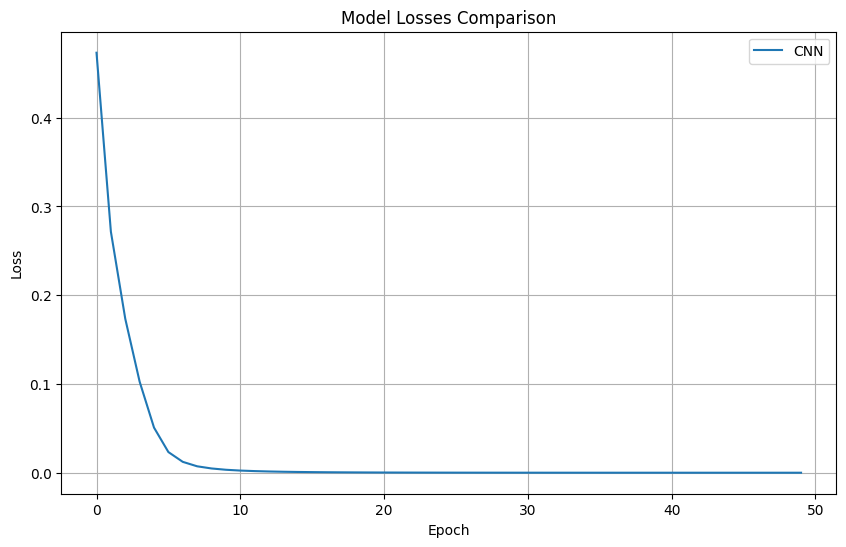

In [31]:
# for all models in the lossesDict, make one plot
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
for model_name, losses in lossesDict.items():
    plt.plot(losses, label=model_name)

plt.title('Model Losses Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Next Steps

In the next notebook, the improvements we will make are:
- packed padded sequences
- pre-trained word embeddings
- different RNN architecture
- bidirectional RNN
- multi-layer RNN
- regularization
- a different optimizer

This will allow us to achieve ~84% accuracy.